Installing Dependencies

In [1]:
!pip3 install tensorflow==1.15.2
!pip3 install numpy==1.19.5
!pip3 install keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 1.2 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 3.8 MB 56.7 MB/s 
     |████████████████████████████████| 503 kB 64.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e1b8f1917a77a19eea8aa6fa1e87da69548b473b92a41a6427edafdde1aa8139
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting u

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 23.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/ssd_keras

/content/drive/MyDrive/ssd_keras


Importing Libraries

In [3]:
from math import ceil
import numpy as np
from PIL import Image
import os
from imageio import imread
from matplotlib import pyplot as plt
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from keras.models import Model
from keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Reshape, Concatenate
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from keras.optimizers import Adam, SGD
from eval_utils.coco_utils import get_coco_category_maps



Using TensorFlow backend.


Defining Variables

In [4]:
# Set the image size.
img_height = 300
img_width = 300
parent_dir="/content/drive/MyDrive/ssd_keras"
dataset_path= parent_dir+"/coco"
pretrained_weights_path=parent_dir +"/checkpoints"
dir_path = dataset_path+"/val2017"
MS_COCO_train_dataset_images_dir = dataset_path+'/train2017'
MS_COCO_val_dataset_images_dir = dataset_path+'/val2017'
MS_COCO_dataset_train_annotations_filename = dataset_path+'/annotations/instances_train2017.json'
MS_COCO_dataset_val_annotations_filename =dataset_path+'/annotations/instances_val2017.json'

img_channels = 3 
mean_color = [123, 117, 104] 
swap_channels = [2, 1, 0] 
n_classes = 80 
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] 
scales = scales_coco
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] 

steps = [8, 16, 32, 64, 100, 300] 
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] 
variances = [0.1, 0.1, 0.2, 0.2] 

batch_size = 32
initial_epoch   = 0
final_epoch     = 120
steps_per_epoch = 1000



Defining SSD model 

In [5]:
def ssd_300(image_size,
            n_classes,
            mode='training',
            l2_regularization=0.0005,
            min_scale=None,
            max_scale=None,
            scales=None,
            aspect_ratios_global=None,
            aspect_ratios_per_layer=aspect_ratios,
            two_boxes_for_ar1=True,
            steps=steps,
            offsets=None,
            clip_boxes=False,
            variances=[0.1, 0.1, 0.2, 0.2],
            coords='centroids',
            normalize_coords=True,
            subtract_mean=[123, 117, 104],
            divide_by_stddev=None,
            swap_channels=swap_channels,
            confidence_thresh=0.01,
            iou_threshold=0.45,
            top_k=200,
            nms_max_output_size=400,
            return_predictor_sizes=False):


    n_predictor_layers = 6 # The number of predictor conv layers in the network is 6 for the original SSD300.
    n_classes += 1 # Account for the background class.
    l2_reg = l2_regularization # Make the internal name shorter.
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

    ############################################################################
    # Get a few exceptions out of the way.
    ############################################################################

    if aspect_ratios_global is None and aspect_ratios_per_layer is None:
        raise ValueError("`aspect_ratios_global` and `aspect_ratios_per_layer` cannot both be None. At least one needs to be specified.")
    if aspect_ratios_per_layer:
        if len(aspect_ratios_per_layer) != n_predictor_layers:
            raise ValueError("It must be either aspect_ratios_per_layer is None or len(aspect_ratios_per_layer) == {}, but len(aspect_ratios_per_layer) == {}.".format(n_predictor_layers, len(aspect_ratios_per_layer)))

    if (min_scale is None or max_scale is None) and scales is None:
        raise ValueError("Either `min_scale` and `max_scale` or `scales` need to be specified.")
    if scales:
        if len(scales) != n_predictor_layers+1:
            raise ValueError("It must be either scales is None or len(scales) == {}, but len(scales) == {}.".format(n_predictor_layers+1, len(scales)))
    else: # If no explicit list of scaling factors was passed, compute the list of scaling factors from `min_scale` and `max_scale`
        scales = np.linspace(min_scale, max_scale, n_predictor_layers+1)

    if len(variances) != 4:
        raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
    variances = np.array(variances)
    if np.any(variances <= 0):
        raise ValueError("All variances must be >0, but the variances given are {}".format(variances))

    if (not (steps is None)) and (len(steps) != n_predictor_layers):
        raise ValueError("You must provide at least one step value per predictor layer.")

    if (not (offsets is None)) and (len(offsets) != n_predictor_layers):
        raise ValueError("You must provide at least one offset value per predictor layer.")

    ############################################################################
    # Compute the anchor box parameters.
    ############################################################################

    # Set the aspect ratios for each predictor layer. These are only needed for the anchor box layers.
    if aspect_ratios_per_layer:
        aspect_ratios = aspect_ratios_per_layer
    else:
        aspect_ratios = [aspect_ratios_global] * n_predictor_layers

    # Compute the number of boxes to be predicted per cell for each predictor layer.
    # We need this so that we know how many channels the predictor layers need to have.
    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1) # +1 for the second box for aspect ratio 1
            else:
                n_boxes.append(len(ar))
    else: # If only a global aspect ratio list was passed, then the number of boxes is the same for each predictor layer
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    ############################################################################
    # Define functions for the Lambda layers below.
    ############################################################################

    def identity_layer(tensor):
        return tensor

    def input_mean_normalization(tensor):
        return tensor - np.array(subtract_mean)

    def input_stddev_normalization(tensor):
        return tensor / np.array(divide_by_stddev)

    def input_channel_swap(tensor):
        if len(swap_channels) == 3:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]]], axis=-1)
        elif len(swap_channels) == 4:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]], tensor[...,swap_channels[3]]], axis=-1)

    ############################################################################
    # Build the network.
    ############################################################################

    x = Input(shape=(img_height, img_width, img_channels))

    # The following identity layer is only needed so that the subsequent lambda layers can be optional.
    x1 = Lambda(identity_layer, output_shape=(img_height, img_width, img_channels), name='identity_layer')(x)
    if not (subtract_mean is None):
        x1 = Lambda(input_mean_normalization, output_shape=(img_height, img_width, img_channels), name='input_mean_normalization')(x1)
    if not (divide_by_stddev is None):
        x1 = Lambda(input_stddev_normalization, output_shape=(img_height, img_width, img_channels), name='input_stddev_normalization')(x1)
    if swap_channels:
        x1 = Lambda(input_channel_swap, output_shape=(img_height, img_width, img_channels), name='input_channel_swap')(x1)

    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_1')(x1)
    conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_2')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)

    conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_1')(pool1)
    conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_2')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)

    conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_1')(pool2)
    conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_3')(conv3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)

    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_1')(pool3)
    conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3')(conv4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)

    conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_1')(pool4)
    conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_3')(conv5_2)
    pool5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='pool5')(conv5_3)

    fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc6')(pool5)

    fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7')(fc6)

    conv6_1 = Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_1')(fc7)
    conv6_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv6_padding')(conv6_1)
    conv6_2 = Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2')(conv6_1)

    conv7_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_1')(conv6_2)
    conv7_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv7_padding')(conv7_1)
    conv7_2 = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2')(conv7_1)

    conv8_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_1')(conv7_2)
    conv8_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2')(conv8_1)

    conv9_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_1')(conv8_2)
    conv9_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2')(conv9_1)

    # Feed conv4_3 into the L2 normalization layer
    conv4_3_norm = L2Normalization(gamma_init=20, name='conv4_3_norm')(conv4_3)

    ### Build the convolutional predictor layers on top of the base network

    # We precidt `n_classes` confidence values for each box, hence the confidence predictors have depth `n_boxes * n_classes`
    # Output shape of the confidence layers: `(batch, height, width, n_boxes * n_classes)`
    conv4_3_norm_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_conf')(conv4_3_norm)
    fc7_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(fc7)
    conv6_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv6_2)
    conv7_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv7_2)
    conv8_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(conv8_2)
    conv9_2_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_conf')(conv9_2)
    # We predict 4 box coordinates for each box, hence the localization predictors have depth `n_boxes * 4`
    # Output shape of the localization layers: `(batch, height, width, n_boxes * 4)`
    conv4_3_norm_mbox_loc = Conv2D(n_boxes[0] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_loc')(conv4_3_norm)
    fc7_mbox_loc = Conv2D(n_boxes[1] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_loc')(fc7)
    conv6_2_mbox_loc = Conv2D(n_boxes[2] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_loc')(conv6_2)
    conv7_2_mbox_loc = Conv2D(n_boxes[3] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_loc')(conv7_2)
    conv8_2_mbox_loc = Conv2D(n_boxes[4] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_loc')(conv8_2)
    conv9_2_mbox_loc = Conv2D(n_boxes[5] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_loc')(conv9_2)

    ### Generate the anchor boxes (called "priors" in the original Caffe/C++ implementation, so I'll keep their layer names)

    # Output shape of anchors: `(batch, height, width, n_boxes, 8)`
    conv4_3_norm_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],
                                             two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0], clip_boxes=clip_boxes,
                                             variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv4_3_norm_mbox_priorbox')(conv4_3_norm_mbox_loc)
    fc7_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],
                                    two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[1], this_offsets=offsets[1], clip_boxes=clip_boxes,
                                    variances=variances, coords=coords, normalize_coords=normalize_coords, name='fc7_mbox_priorbox')(fc7_mbox_loc)
    conv6_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[2], this_offsets=offsets[2], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv6_2_mbox_priorbox')(conv6_2_mbox_loc)
    conv7_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[3], this_offsets=offsets[3], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv7_2_mbox_priorbox')(conv7_2_mbox_loc)
    conv8_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[4], next_scale=scales[5], aspect_ratios=aspect_ratios[4],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[4], this_offsets=offsets[4], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv8_2_mbox_priorbox')(conv8_2_mbox_loc)
    conv9_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[5], next_scale=scales[6], aspect_ratios=aspect_ratios[5],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[5], this_offsets=offsets[5], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv9_2_mbox_priorbox')(conv9_2_mbox_loc)

    ### Reshape

    # Reshape the class predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, n_classes)`
    # We want the classes isolated in the last axis to perform softmax on them
    conv4_3_norm_mbox_conf_reshape = Reshape((-1, n_classes), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_conf)
    fc7_mbox_conf_reshape = Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
    conv6_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
    conv7_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
    conv8_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
    conv9_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv9_2_mbox_conf_reshape')(conv9_2_mbox_conf)
    # Reshape the box predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, 4)`
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    conv4_3_norm_mbox_loc_reshape = Reshape((-1, 4), name='conv4_3_norm_mbox_loc_reshape')(conv4_3_norm_mbox_loc)
    fc7_mbox_loc_reshape = Reshape((-1, 4), name='fc7_mbox_loc_reshape')(fc7_mbox_loc)
    conv6_2_mbox_loc_reshape = Reshape((-1, 4), name='conv6_2_mbox_loc_reshape')(conv6_2_mbox_loc)
    conv7_2_mbox_loc_reshape = Reshape((-1, 4), name='conv7_2_mbox_loc_reshape')(conv7_2_mbox_loc)
    conv8_2_mbox_loc_reshape = Reshape((-1, 4), name='conv8_2_mbox_loc_reshape')(conv8_2_mbox_loc)
    conv9_2_mbox_loc_reshape = Reshape((-1, 4), name='conv9_2_mbox_loc_reshape')(conv9_2_mbox_loc)
    # Reshape the anchor box tensors, yielding 3D tensors of shape `(batch, height * width * n_boxes, 8)`
    conv4_3_norm_mbox_priorbox_reshape = Reshape((-1, 8), name='conv4_3_norm_mbox_priorbox_reshape')(conv4_3_norm_mbox_priorbox)
    fc7_mbox_priorbox_reshape = Reshape((-1, 8), name='fc7_mbox_priorbox_reshape')(fc7_mbox_priorbox)
    conv6_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv6_2_mbox_priorbox_reshape')(conv6_2_mbox_priorbox)
    conv7_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv7_2_mbox_priorbox_reshape')(conv7_2_mbox_priorbox)
    conv8_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv8_2_mbox_priorbox_reshape')(conv8_2_mbox_priorbox)
    conv9_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv9_2_mbox_priorbox_reshape')(conv9_2_mbox_priorbox)

    ### Concatenate the predictions from the different layers

    # Axis 0 (batch) and axis 2 (n_classes or 4, respectively) are identical for all layer predictions,
    # so we want to concatenate along axis 1, the number of boxes per layer
    # Output shape of `mbox_conf`: (batch, n_boxes_total, n_classes)
    mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv4_3_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       conv9_2_mbox_conf_reshape])

    # Output shape of `mbox_loc`: (batch, n_boxes_total, 4)
    mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv4_3_norm_mbox_loc_reshape,
                                                     fc7_mbox_loc_reshape,
                                                     conv6_2_mbox_loc_reshape,
                                                     conv7_2_mbox_loc_reshape,
                                                     conv8_2_mbox_loc_reshape,
                                                     conv9_2_mbox_loc_reshape])

    # Output shape of `mbox_priorbox`: (batch, n_boxes_total, 8)
    mbox_priorbox = Concatenate(axis=1, name='mbox_priorbox')([conv4_3_norm_mbox_priorbox_reshape,
                                                               fc7_mbox_priorbox_reshape,
                                                               conv6_2_mbox_priorbox_reshape,
                                                               conv7_2_mbox_priorbox_reshape,
                                                               conv8_2_mbox_priorbox_reshape,
                                                               conv9_2_mbox_priorbox_reshape])

    # The box coordinate predictions will go into the loss function just the way they are,
    # but for the class predictions, we'll apply a softmax activation layer first
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)

    # Concatenate the class and box predictions and the anchors to one large predictions vector
    # Output shape of `predictions`: (batch, n_boxes_total, n_classes + 4 + 8)
    predictions = Concatenate(axis=2, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_priorbox])

    if mode == 'training':
        model = Model(inputs=x, outputs=predictions)
    elif mode == 'inference':
        decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                               iou_threshold=iou_threshold,
                                               top_k=top_k,
                                               nms_max_output_size=nms_max_output_size,
                                               coords=coords,
                                               normalize_coords=True,
                                               img_height=img_height,
                                               img_width=img_width,
                                               name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    elif mode == 'inference_fast':
        decoded_predictions = DecodeDetectionsFast(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   normalize_coords=True,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    else:
        raise ValueError("`mode` must be one of 'training', 'inference' or 'inference_fast', but received '{}'.".format(mode))

    if return_predictor_sizes:
        predictor_sizes = np.array([conv4_3_norm_mbox_conf._keras_shape[1:3],
                                     fc7_mbox_conf._keras_shape[1:3],
                                     conv6_2_mbox_conf._keras_shape[1:3],
                                     conv7_2_mbox_conf._keras_shape[1:3],
                                     conv8_2_mbox_conf._keras_shape[1:3],
                                     conv9_2_mbox_conf._keras_shape[1:3]])
        return model, predictor_sizes
    else:
        return model


Downloading MSCOCO Dataset and Loading Dataset
 , size=26GB

In [6]:
if os.path.exists(dataset_path) is False:
  print("Downloading Dataset")
  os.makedirs(dataset_path, exist_ok=True)
  !wget  http://images.cocodataset.org/zips/val2017.zip -O /content/drive/MyDrive/ssd_keras/coco/val2017.zip
  #Uncomment if training Dataset is required(Needed only for training)
  #!wget  http://images.cocodataset.org/zips/train2017.zip -O /content/drive/MyDrive/ssd_keras/coco/train2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O /content/drive/MyDrive/ssd_keras/coco/annotations_trainval2017.zip
  
#Uncomment to download and extract train data (Needed only for training)

  %cd /content/drive/MyDrive/ssd_keras/coco
  !unzip /content/drive/MyDrive/ssd_keras/coco/val2017.zip
  #!unzip /content/drive/MyDrive/ssd_keras/coco/train2017.zip
  !unzip /content/drive/MyDrive/ssd_keras/coco/annotations_trainval2017.zip
  %cd /content/drive/MyDrive/ssd_keras
else:
  print("Dataset already Downloaded")

# Please Uncomment code below if you want to load the data for training


# train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
# val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)


# train_dataset.parse_json(images_dirs=[MS_COCO_train_dataset_images_dir],
#                    annotations_filenames=[MS_COCO_dataset_train_annotations_filename],
#                    ground_truth_available=True, # It doesn't matter whether you set this `True` or `False` because the ground truth won't be used anyway, but the parsing goes faster if you don't load the ground truth.
#                    include_classes='all',
#                    ret=False)

# val_dataset.parse_json(images_dirs=[MS_COCO_val_dataset_images_dir],
#                    annotations_filenames=[MS_COCO_dataset_val_annotations_filename],
#                    ground_truth_available=True, # It doesn't matter whether you set this `True` or `False` because the ground truth won't be used anyway, but the parsing goes faster if you don't load the ground truth.
#                    include_classes='all',
#                    ret=False)


# cats_to_classes, classes_to_cats, cats_to_names, classes_to_names = get_coco_category_maps(MS_COCO_dataset_val_annotations_filename)

Dataset already Downloaded


Downloading weights for training and Inference

In [7]:
if os.path.exists(pretrained_weights_path) is False:
  print("Downloading pretrained weights")
  os.makedirs(pretrained_weights_path, exist_ok=True)
  %cd /content/drive/MyDrive/ssd_keras/checkpoints
  !gdown https://drive.google.com/u/0/uc?id=1vmEF7FUsWfHquXyCqO17UaXOPpRbwsdj&export=download
  !gdown https://drive.google.com/u/0/uc?id=1sBmajn6vOE7qJ8GnxUJt4fGPuffVUZox&export=download
else:
  print('Already Downloaded')
  %cd /content/drive/MyDrive/ssd_keras


Already Downloaded
/content/drive/MyDrive/ssd_keras


Compiling SSD Model


In [14]:
K.clear_session() # Clear previous models from memory.


def compile_model(mode):
  model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode=mode,
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=True,
                steps=steps,
                offsets=offsets,
                clip_boxes=False,
                variances=variances,
                normalize_coords=True,
                subtract_mean=mean_color,
                swap_channels=swap_channels)
  return model
model = compile_model('training')

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = "/content/drive/MyDrive/ssd_keras/checkpoints/VGG_ILSVRC_16_layers_fc_reduced.h5"
model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma


Model for Training

In [ ]:
# 1: Build the Keras model.
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:MM
        return 0.0001
    else:
        return 0.00001

ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=True,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=False,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=True)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                                  'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))



# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath=pretrained_weights_path+'/ssd_coco.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_coco_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]



history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)


Inference

In [15]:
K.clear_session() # Clear previous models from memory.

model = compile_model('inference')
# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = '/content/drive/MyDrive/ssd_keras/checkpoints/VGG_coco_SSD_300x300_iter_400000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma


Inference

<Figure size 1296x1296 with 0 Axes>

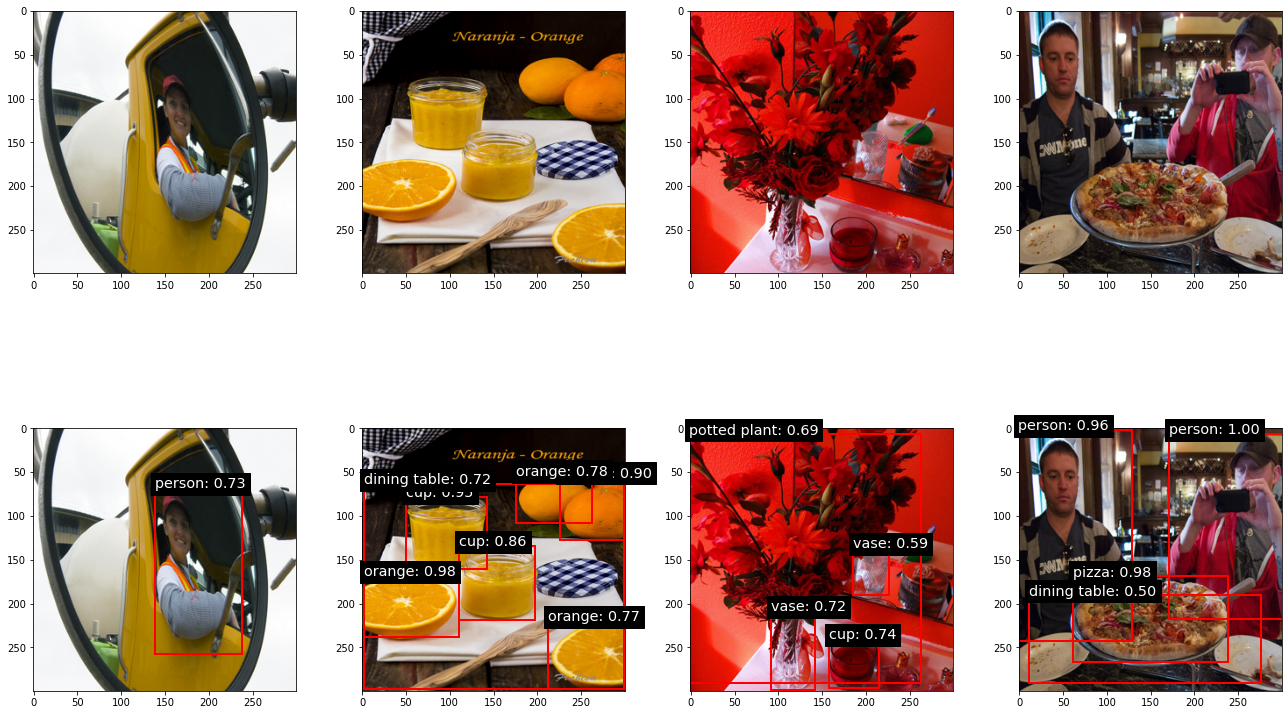

In [16]:
classes = {0: u'__background__',
 1: u'person',
 2: u'bicycle',
 3: u'car',
 4: u'motorcycle',
 5: u'airplane',
 6: u'bus',
 7: u'train',
 8: u'truck',
 9: u'boat',
 10: u'traffic light',
 11: u'fire hydrant',
 12: u'stop sign',
 13: u'parking meter',
 14: u'bench',
 15: u'bird',
 16: u'cat',
 17: u'dog',
 18: u'horse',
 19: u'sheep',
 20: u'cow',
 21: u'elephant',
 22: u'bear',
 23: u'zebra',
 24: u'giraffe',
 25: u'backpack',
 26: u'umbrella',
 27: u'handbag',
 28: u'tie',
 29: u'suitcase',
 30: u'frisbee',
 31: u'skis',
 32: u'snowboard',
 33: u'sports ball',
 34: u'kite',
 35: u'baseball bat',
 36: u'baseball glove',
 37: u'skateboard',
 38: u'surfboard',
 39: u'tennis racket',
 40: u'bottle',
 41: u'wine glass',
 42: u'cup',
 43: u'fork',
 44: u'knife',
 45: u'spoon',
 46: u'bowl',
 47: u'banana',
 48: u'apple',
 49: u'sandwich',
 50: u'orange',
 51: u'broccoli',
 52: u'carrot',
 53: u'hot dog',
 54: u'pizza',
 55: u'donut',
 56: u'cake',
 57: u'chair',
 58: u'couch',
 59: u'potted plant',
 60: u'bed',
 61: u'dining table',
 62: u'toilet',
 63: u'tv',
 64: u'laptop',
 65: u'mouse',
 66: u'remote',
 67: u'keyboard',
 68: u'cell phone',
 69: u'microwave',
 70: u'oven',
 71: u'toaster',
 72: u'sink',
 73: u'refrigerator',
 74: u'book',
 75: u'clock',
 76: u'vase',
 77: u'scissors',
 78: u'teddy bear',
 79: u'hair drier',
 80: u'toothbrush'}

orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.
dir = os.listdir(dir_path) 
path_img=dir[0:4]
plt.figure(figsize=(18,18))
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(18,18))
# We'll only load one image in this example.
k=1
j=5
for i in path_img:

  orig_images = [] # Store the images here.
  input_images = [] # Store resized versions of the images here.
  img_path=dir_path+"/"+i
  orig_images.append(imread(img_path))
  img = image.load_img(img_path, target_size=(img_height, img_width))
  img = image.img_to_array(img) 
  input_images.append(img)
  input_images = np.array(input_images)
  y_pred = model.predict(input_images)
  confidence_threshold = 0.5

  y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

  np.set_printoptions(precision=2, suppress=True, linewidth=90)
  # print("Predicted boxes:\n")
  # print('   class   conf xmin   ymin   xmax   ymax')
  # print(y_pred_thresh[0])
  colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
  plt.subplot(2,4,k)
  img=Image.open(img_path)
  img=img.resize((300,300))
  plt.imshow(img)
  plt.subplot(2,4,j)
  orig_image=Image.fromarray(orig_images[0])
  orig_image=orig_image.resize((300,300))
  plt.imshow(orig_image)
  current_axis = plt.gca()
  j=j+1
  k=k+1

  for box in y_pred_thresh[0]:
      # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
      xmin = box[2]# * orig_images[0].shape[1] / img_width
      ymin = box[3]# * orig_images[0].shape[0] / img_height
      xmax = box[4]# * orig_images[0].shape[1] / img_width
      ymax = box[5]# * orig_images[0].shape[0] / img_height
      #color = colors[int(box[0])]

      label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
      current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,color='red' , fill=False, linewidth=2))  
      current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'black', 'alpha':1.0})
